In [2]:
import torch
import numpy as np
from transformers import LlamaTokenizer, GenerationConfig

/home/xingyao6/opt/miniconda3/envs/solo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Add project root to sys path to import image_utils
import os
import sys

current_dir = os.getcwd()
project_root = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, project_root)

from image_utils import (
    load_image_to_base64,
    download_image_to_base64,
    load_base64_to_PILImage,
    convert_image_base64_to_patches,
    visualize_patches
)

In [4]:
# if you did `pip install git+https://github.com/xingyaoww/transformers.git@solo`
from transformers import SoloForCausalLM

# Otherwise
# from scripts.model.modeling_solo import SoloForCausalLM

In [5]:
MODEL_PATH = f"{project_root}/data/models/SOLO-7B"

tokenizer = LlamaTokenizer.from_pretrained(MODEL_PATH)
model = SoloForCausalLM.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16)

DEVICE = "cuda:0"
model = model.to(DEVICE)

Loading checkpoint shards: 100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


In [6]:
# Check tokenizer for reserved token for vision
print(sorted(tokenizer.get_vocab().items(), key=lambda x: x[1], reverse=True)[1020:1030])

[('<loc_4>', 32008), ('<loc_3>', 32007), ('<loc_2>', 32006), ('<loc_1>', 32005), ('</vision>', 32004), ('<vframe_sep>', 32003), ('<vrow_sep>', 32002), ('<vpatch>', 32001), ('<vision>', 32000), ('梦', 31999)]


## Utility

In [7]:
def prepare_inputs(inputs: list, device: str):
    NON_VISION_TOKEN = -1
    
    tokens = []
    attention_masks = []
    vision_patch_indices = []
    vision_patches = []
    
    for i in inputs:
        if isinstance(i, torch.Tensor):
            # this is patches
            patches = i
            n_rows, n_cols = patches.shape[:2]
            n_patches = n_rows * n_cols
            patches = patches.view(n_patches, -1)
            
            # ---
            img_tokens = ["<vision>"]
            cur_patch_indices = [NON_VISION_TOKEN]
            for row_idx in range(n_rows):
                for col_idx in range(n_cols):
                    if row_idx != 0 and col_idx == 0: # when new row starts
                        img_tokens.append(f"<vrow_sep>")
                        cur_patch_indices.append(NON_VISION_TOKEN)
                    img_tokens.append(f"<vpatch>")
                    cur_patch_indices.append(len(vision_patches) + row_idx * n_cols + col_idx)
            img_tokens.append("<vision>")
            cur_patch_indices.append(NON_VISION_TOKEN)
            
            # ---
            # NOTE tokenizer(xxx) will NOT work here
            cur_tokens = torch.Tensor(tokenizer.convert_tokens_to_ids(img_tokens))
            cur_attention_mask = [1] * len(cur_tokens)
            # print(f"cur_tokens: {cur_tokens}")
            # print(f"cur_attention_mask: {cur_attention_mask}")
            # print(f"cur_patch_indices: {cur_patch_indices}")
            assert len(cur_tokens) == len(cur_patch_indices), f"{len(cur_tokens)} != {len(cur_patch_indices)}"
            
            tokens.extend(cur_tokens)
            attention_masks.extend(cur_attention_mask)
            vision_patch_indices.extend(cur_patch_indices)
            vision_patches.extend(patches.numpy().astype(np.float16))

        elif isinstance(i, str):
            include_bos = len(tokens) == 0
            _tokenized = tokenizer(i, return_tensors="pt", add_special_tokens=include_bos)
            cur_tokens = _tokenized["input_ids"].squeeze(0)
            cur_attention_mask = _tokenized["attention_mask"].squeeze(0)
            print(f"cur_tokens: {cur_tokens}")
            print(f"cur_attention_mask: {cur_attention_mask}")

            tokens.extend(cur_tokens)
            attention_masks.extend(cur_attention_mask)
            vision_patch_indices.extend([NON_VISION_TOKEN] * len(cur_tokens))

    tokens = torch.Tensor(tokens).long()
    attention_masks = torch.Tensor(attention_masks).long()
    if len(vision_patches) > 0:
        vision_patches = torch.Tensor(vision_patches).bfloat16()
    else:
        vision_patches = None
    vision_patch_indices = torch.Tensor(vision_patch_indices).long()

    # move to device
    tokens = tokens.to(device)
    attention_masks = attention_masks.to(device)
    vision_patch_indices = vision_patch_indices.to(device)
    if vision_patches is not None:
        vision_patches = vision_patches.to(device)
    return tokens, attention_masks, vision_patches, vision_patch_indices



In [8]:
def visualize_outputs(inputs, tokens, outputs):
    for idx, s in enumerate(inputs):
        if isinstance(s, str):
            if idx == len(inputs) - 1:
                print(s, end=" [")
                print(tokenizer.decode(outputs[0, len(tokens):], skip_special_tokens=True) + "]")
            else:
                print(s)
        else:
            visualize_patches(s, figsize=(4, 4))

In [9]:
def run_inference_and_print_outputs(
    inputs,
    do_sample=False,
    top_p=0.95,
    max_new_tokens=30,
):
    tokens, attention_masks, vision_patches, vision_patch_indices = prepare_inputs(inputs, device=DEVICE)
    # generate text
    with torch.no_grad():

        outputs = model.generate(
            input_ids=tokens.unsqueeze(0),
            # model_kwargs
            attention_mask=attention_masks.unsqueeze(0),
            vision_patches=vision_patches,
            vision_patch_indices=vision_patch_indices.unsqueeze(0),
            generation_config=GenerationConfig(
                do_sample=do_sample,
                top_p=top_p,
                max_new_tokens=max_new_tokens,
                # repetition_penalty=1.2,
                pad_token_id=tokenizer.eos_token_id,
                # anything above 32000 (vision related tokens) will be suppressed
                suppress_tokens=[i for i in range(32000, len(tokenizer))],
            ),
        )
    visualize_outputs(inputs, tokens, outputs)

## Run Inference

patch shape: torch.Size([32, 32, 3, 32, 32])


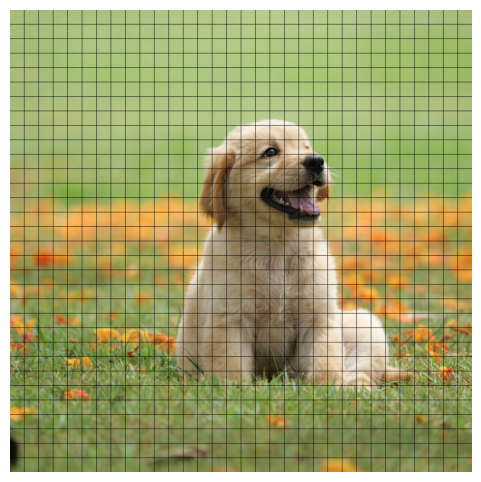

In [10]:
dog_img_base64 = load_image_to_base64(f"{project_root}/images/dog.jpg")
dog_img_patches = convert_image_base64_to_patches(dog_img_base64)
print(f"patch shape: {dog_img_patches.shape}")
visualize_patches(dog_img_patches)

cur_tokens: tensor([851, 349, 264])
cur_attention_mask: tensor([1, 1, 1])


/tmp/ipykernel_2469237/750559189.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  vision_patches = torch.Tensor(vision_patches).bfloat16()


/shared/nas2/xingyao6/projects/transformers/src/transformers/generation/configuration_utils.py:545: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/shared/nas2/xingyao6/projects/transformers/src/transformers/generation/configuration_utils.py:545: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


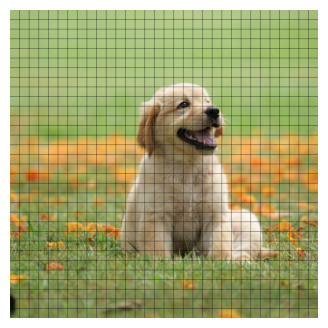

This is a [golden retriever puppy sitting in a field of flowers.]


In [11]:
# prepare input for the model
inputs = [
    dog_img_patches,
    "This is a"
]
run_inference_and_print_outputs(inputs)

patch shape: torch.Size([15, 32, 3, 32, 32])


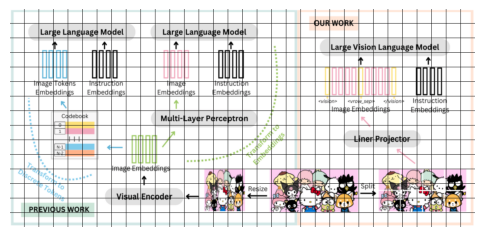

In [12]:
fig1_img_base64 = load_image_to_base64(f"{project_root}/images/fig1.png")
fig1_img_patches = convert_image_base64_to_patches(fig1_img_base64)
print(f"patch shape: {fig1_img_patches.shape}")
visualize_patches(fig1_img_patches)

cur_tokens: tensor([13702,   426,   272,  5248,   297,  8291, 28723])
cur_attention_mask: tensor([1, 1, 1, 1, 1, 1, 1])


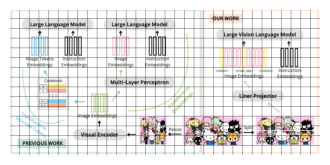

Explain the figure in detail. [The image is a vibrant and informative graphic that explains the concept of Large Language Model (LLM). The background is a clean white, providing]


In [13]:
inputs = [
    fig1_img_patches,
    "Explain the figure in detail."
]
run_inference_and_print_outputs(inputs)